I've enhanced the colon simulation with several key improvements:

Darker Central Area:

The colon tube now has a darker center that gradually lightens toward the edges
This creates a more realistic depth effect, simulating how light diminishes deeper in the colon


More Contrasting Folds:

The concentric rings now alternate between lighter and darker shades
Fold widths vary randomly within a specified range
Added more folds (6 instead of 5) for a more detailed appearance


Depth and Perspective Effects:

Outer folds are more pronounced with higher opacity
The squish factor changes with distance (more circular as we move outward)
Added highlight effects on the upper parts of some folds to simulate light reflection


Center Simulation:

Created a dark central area with a gradient effect
This simulates the natural darkness and tunnel-like appearance of the colon lumen



These changes will make the synthetic images more realistic and provide better contrast for the polyp detection task. The alternating light and dark patterns of the folds will better mimic the appearance of real colon tissue in colonoscopy images.

Using device: cpu


Generating synthetic data:   0%|          | 0/100 [00:00<?, ?it/s]

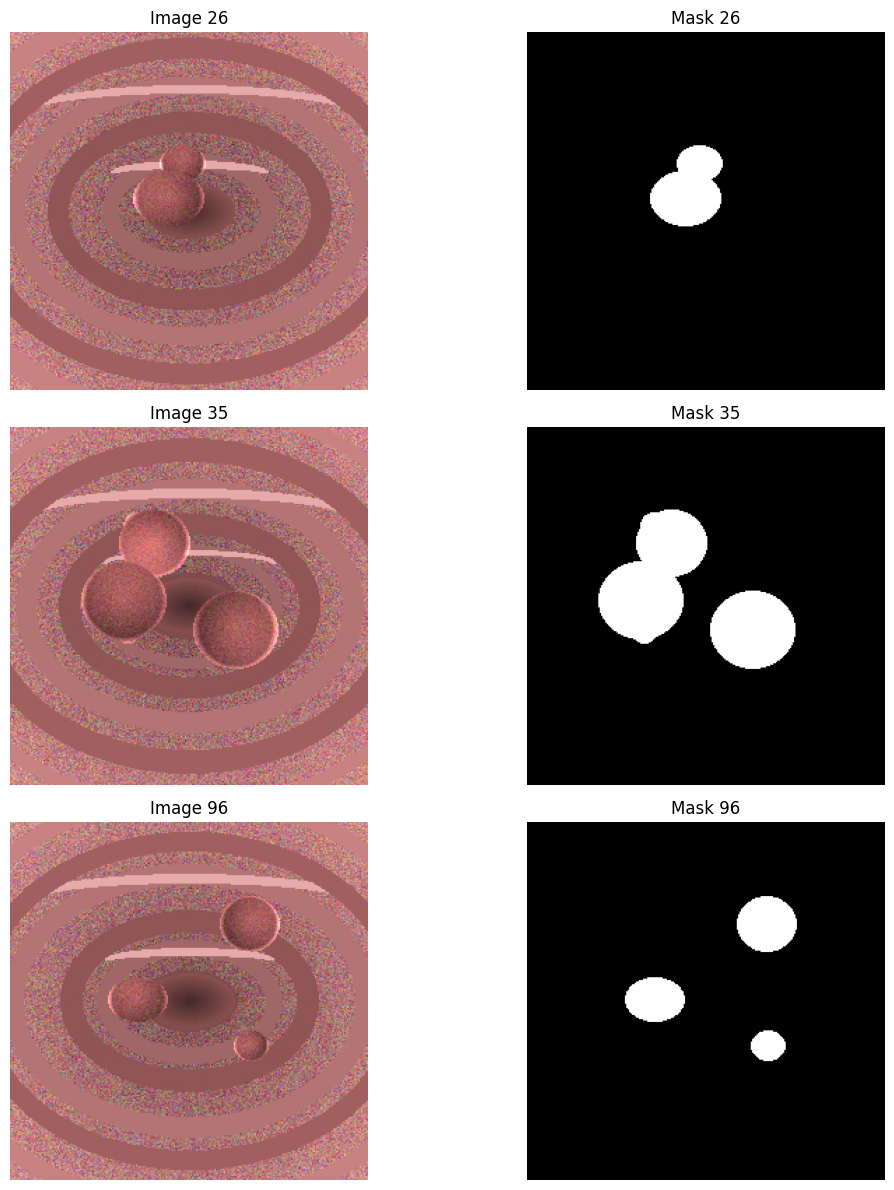

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [2]:
# Colon Polyp Detection - Synthetic Data Generation and ML Model
# Google Colab Notebook

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Create directories for saving images
os.makedirs('synthetic_colon_data/images', exist_ok=True)
os.makedirs('synthetic_colon_data/masks', exist_ok=True)

# Part 1: Enhanced Synthetic Colon Image Generation
# ---------------------------------------

def generate_colon_background(img_size=256, noise_factor=0.1):
    """Generate a synthetic colon background with a pinkish color and darker center."""
    # Base pink color for colon tissue
    base_color = np.array([210, 140, 140])  # Pinkish color

    # Create base image
    img = np.ones((img_size, img_size, 3))

    # Add radial gradient for tube-like appearance with darker center
    y, x = np.ogrid[:img_size, :img_size]
    center = img_size // 2
    dist_from_center = np.sqrt((x - center)**2 + (y - center)**2)

    # Normalize to [0, 1]
    dist_from_center = dist_from_center / (np.sqrt(2) * center)

    # Make center darker - add stronger vignetting effect
    for c in range(3):
        # More dramatic darkening in the center
        img[:, :, c] = base_color[c] / 255.0 * (0.6 + 0.4 * dist_from_center)

    # Add noise for texture
    noise = np.random.randn(img_size, img_size, 3) * noise_factor
    img += noise
    img = np.clip(img, 0, 1)

    return img

def add_colon_folds(img, num_folds=6, fold_width_range=(8, 15)):
    """Add concentric rings/folds to the colon image with more contrast."""
    img_size = img.shape[0]
    center = img_size // 2

    # Convert to PIL for drawing
    pil_img = Image.fromarray((img * 255).astype(np.uint8))
    draw = ImageDraw.Draw(pil_img)

    # Draw concentric circles for colon folds with alternating brightness
    for i in range(1, num_folds + 1):
        radius = (img_size // (num_folds + 2)) * i

        # Add slight randomness to fold placement
        radius += random.randint(-5, 5)

        # Alternating fold brightness for more contrast
        if i % 2 == 0:
            # Lighter fold
            fold_color = (200, 130, 130)  # Lighter pink
            fold_width = random.randint(fold_width_range[0], fold_width_range[1])
        else:
            # Darker fold
            fold_color = (170, 100, 100)  # Darker pink
            fold_width = random.randint(fold_width_range[0] + 2, fold_width_range[1] + 2)  # Slightly wider

        # Draw with varying opacity based on distance from center for perspective
        opacity_factor = 0.7 + 0.3 * (i / num_folds)  # More pronounced outer folds
        adjusted_color = tuple(int(c * opacity_factor) for c in fold_color)

        # Draw squished ellipses for perspective (more squished near center)
        squish_factor = 0.6 + 0.2 * (i / num_folds)  # More circular as we move outward
        ellipse_bounds = [
            center - radius,
            center - radius * squish_factor,
            center + radius,
            center + radius * squish_factor
        ]

        # Draw the fold
        draw.ellipse(ellipse_bounds, outline=adjusted_color, width=fold_width)

        # Add highlight effect on the upper part of some folds for depth
        if i % 2 == 0 and i > 1:
            highlight_bounds = [
                center - radius + fold_width//2,
                center - radius * squish_factor + fold_width//2,
                center + radius - fold_width//2,
                center - radius * squish_factor//2
            ]
            # Partial highlight arc
            draw.arc(highlight_bounds, 180, 360, fill=(230, 170, 170), width=fold_width//2)

    # Add a dark central area to simulate depth
    central_radius = img_size // (num_folds + 2)
    central_ellipse = [
        center - central_radius,
        center - central_radius * 0.6,
        center + central_radius,
        center + central_radius * 0.6
    ]
    # Draw dark central area with gradient
    for r in range(central_radius, 0, -2):
        darkness = 0.6 - (r / central_radius) * 0.4  # Darker toward center
        dark_color = tuple(int(c * (1-darkness)) for c in (170, 100, 100))
        inner_ellipse = [
            center - r,
            center - r * 0.6,
            center + r,
            center + r * 0.6
        ]
        draw.ellipse(inner_ellipse, fill=dark_color, outline=None)

    # Convert back to numpy
    img = np.array(pil_img) / 255.0
    return img

def generate_polyp(img_size=256, min_radius=10, max_radius=30):
    """Generate a polyp mask and the polyp appearance."""
    mask = np.zeros((img_size, img_size), dtype=np.uint8)

    # Random position for the polyp
    center_x = random.randint(img_size // 4, 3 * img_size // 4)
    center_y = random.randint(img_size // 4, 3 * img_size // 4)

    # Random radius for the polyp
    radius = random.randint(min_radius, max_radius)

    # Create a PIL image for drawing
    mask_img = Image.fromarray(mask)
    draw = ImageDraw.Draw(mask_img)

    # Draw an ellipse for the polyp (slightly irregular)
    squish_factor = random.uniform(0.7, 1.0)
    ellipse_bounds = [
        center_x - radius,
        center_y - radius * squish_factor,
        center_x + radius,
        center_y + radius * squish_factor
    ]
    draw.ellipse(ellipse_bounds, fill=1)

    # Add irregularity to some polyps (about 40% of polyps)
    if random.random() < 0.4:
        # Add a random "bump" to the polyp
        bump_angle = random.uniform(0, 2 * np.pi)
        bump_distance = radius * 0.7
        bump_size = radius * random.uniform(0.3, 0.5)

        bump_x = center_x + bump_distance * np.cos(bump_angle)
        bump_y = center_y + bump_distance * np.sin(bump_angle)

        bump_bounds = [
            bump_x - bump_size,
            bump_y - bump_size,
            bump_x + bump_size,
            bump_y + bump_size
        ]
        draw.ellipse(bump_bounds, fill=1)

    # Convert back to numpy
    mask = np.array(mask_img)

    # For polyp appearance (reddish/darker color with texture)
    polyp_color = np.array([180, 100, 100]) / 255.0  # Darker red

    # Make some polyps more pinkish (variety)
    if random.random() < 0.3:
        polyp_color = np.array([220, 120, 120]) / 255.0  # More pinkish

    # Add slight texture variation
    polyp_texture = generate_polyp_texture(mask, polyp_color)

    return mask, polyp_texture

def generate_polyp_texture(mask, base_color):
    """Generate texture for the polyp with more realistic appearance."""
    img_size = mask.shape[0]
    texture = np.zeros((img_size, img_size, 3))

    # Find the center and radius of the polyp
    y_indices, x_indices = np.where(mask > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        return texture

    center_y = int(np.mean(y_indices))
    center_x = int(np.mean(x_indices))

    # Estimate radius as distance to furthest point
    max_dist = 0
    for y, x in zip(y_indices, x_indices):
        dist = np.sqrt((y - center_y)**2 + (x - center_x)**2)
        max_dist = max(max_dist, dist)

    # Create a distance map from center for shading
    y, x = np.ogrid[:img_size, :img_size]
    dist_from_center = np.sqrt((y - center_y)**2 + (x - center_x)**2)

    # Normalize distances for shading (0 at center, 1 at edge)
    normalized_dist = np.zeros_like(dist_from_center)
    mask_indices = mask > 0
    if np.any(mask_indices):
        normalized_dist[mask_indices] = dist_from_center[mask_indices] / max_dist

    # Create highlights and shadows
    highlight_dir = random.uniform(0, 2 * np.pi)  # Random direction for highlight
    highlight_x = np.cos(highlight_dir)
    highlight_y = np.sin(highlight_dir)

    # Calculate highlight intensity based on direction
    y_rel = (y - center_y) / (max_dist + 1e-6)
    x_rel = (x - center_x) / (max_dist + 1e-6)
    directional_component = x_rel * highlight_x + y_rel * highlight_y

    # Create texture with highlight and shadow
    for c in range(3):
        # Base color
        color_map = np.ones((img_size, img_size)) * base_color[c]

        # Add radial shading (darker toward edges)
        edge_darkening = 0.3 * normalized_dist  # Darken up to 30% at edges

        # Add directional highlight (brighten in highlight direction, darken in opposite)
        highlight = 0.2 * directional_component  # +/- 20% variation based on direction

        # Apply both effects where the mask is active
        color_map[mask > 0] = color_map[mask > 0] * (1 - edge_darkening[mask > 0] + highlight[mask > 0])

        # Add some random texture variation
        noise = np.random.randn(img_size, img_size) * 0.05
        color_map[mask > 0] += noise[mask > 0]

        # Ensure values are in valid range
        color_map = np.clip(color_map, 0, 1)

        # Apply to texture
        texture[:, :, c] = mask * color_map

    return texture

def add_polyp_to_image(img, mask, polyp_texture):
    """Add a polyp to the colon image with better blending."""
    # Blend the polyp with the background image
    result = img.copy()

    # Create a blurred edge mask for better blending
    y_indices, x_indices = np.where(mask > 0)
    if len(y_indices) == 0:
        return result

    # Find polyp center and max radius
    center_y = int(np.mean(y_indices))
    center_x = int(np.mean(x_indices))

    # Calculate distances for all polyp pixels
    distances = np.sqrt((y_indices - center_y)**2 + (x_indices - center_x)**2)
    max_dist = np.max(distances)

    # Create a soft edge mask with blur
    soft_mask = mask.copy().astype(float)

    # For each positive pixel in the mask
    for y, x, dist in zip(y_indices, x_indices, distances):
        # If we're near the edge (within 15% of max radius from edge)
        edge_ratio = dist / max_dist
        if edge_ratio > 0.85:
            # Calculate opacity based on distance to edge (1 at core, 0 at edge)
            fade_factor = 1.0 - ((edge_ratio - 0.85) / 0.15)
            soft_mask[y, x] = fade_factor

    # Apply the soft mask for blending
    for c in range(3):
        result[:, :, c] = result[:, :, c] * (1 - soft_mask) + polyp_texture[:, :, c]

    # Ensure values are valid
    result = np.clip(result, 0, 1)

    return result

def generate_dataset(num_images=500, img_size=256):
    """Generate a synthetic dataset of colon images with and without polyps."""
    images = []
    masks = []

    for i in tqdm(range(num_images), desc="Generating synthetic data"):
        # Generate background
        img = generate_colon_background(img_size)
        img = add_colon_folds(img)

        # With 70% probability, add a polyp
        has_polyp = random.random() < 0.7

        if has_polyp:
            # Generate between 1 and 3 polyps
            num_polyps = random.randint(1, 3)
            combined_mask = np.zeros((img_size, img_size))

            for _ in range(num_polyps):
                polyp_mask, polyp_texture = generate_polyp(img_size)
                img = add_polyp_to_image(img, polyp_mask, polyp_texture)
                combined_mask = np.maximum(combined_mask, polyp_mask)
        else:
            combined_mask = np.zeros((img_size, img_size))

        # Save the images and masks
        img_array = (img * 255).astype(np.uint8)
        mask_array = (combined_mask * 255).astype(np.uint8)

        # Save images to disk
        Image.fromarray(img_array).save(f'synthetic_colon_data/images/{i:04d}.png')
        Image.fromarray(mask_array).save(f'synthetic_colon_data/masks/{i:04d}.png')

        # Keep in memory for visualization
        images.append(img)
        masks.append(combined_mask)

    return images, masks

# Generate the dataset
images, masks = generate_dataset(num_images=100)  # Reduced for notebook demonstration

# Visualize some examples
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for i in range(3):
    idx = random.randint(0, len(images) - 1)
    axes[i, 0].imshow(images[idx])
    axes[i, 0].set_title(f"Image {idx}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(masks[idx], cmap='gray')
    axes[i, 1].set_title(f"Mask {idx}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Part 2: PyTorch Dataset and DataLoader
# -------------------------------------

class ColonPolypsDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            # Normalize mask to [0, 1]
            mask = np.array(mask) / 255.0
            mask = torch.from_numpy(mask).float().unsqueeze(0)  # Add channel dim

        return image, mask

# Data augmentation and preprocessing
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.ToTensor()
])

# Create datasets
train_val_dataset = ColonPolypsDataset(
    img_dir='synthetic_colon_data/images',
    mask_dir='synthetic_colon_data/masks',
    transform=None,  # Will apply transforms after splitting
    mask_transform=None
)

# Split into train and validation sets
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

# Apply transforms to the split datasets
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None, mask_transform=None):
        self.subset = subset
        self.transform = transform
        self.mask_transform = mask_transform

    def __getitem__(self, idx):
        image, mask = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            # Normalize mask to [0, 1]
            mask = np.array(mask) / 255.0
            mask = torch.from_numpy(mask).float().unsqueeze(0)  # Add channel dim
        return image, mask

    def __len__(self):
        return len(self.subset)

train_dataset = TransformedSubset(train_dataset, train_transform, mask_transform)
val_dataset = TransformedSubset(val_dataset, val_transform, mask_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Part 3: Model Definition (U-Net for segmentation)
# -----------------------------------------------

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Padding if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                              diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

        self.outc = OutConv(64, n_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return self.sigmoid(logits)

# Initialize the model
model = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)

# Define loss function
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCELoss()

    def forward(self, inputs, targets, smooth=1):
        # BCE Loss
        bce_loss = self.bce(inputs, targets)

        # Dice Loss
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)

        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)

        # Combined loss (BCE + Dice)
        return bce_loss + dice_loss

# Loss function and optimizer
criterion = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Part 4: Training Loop
# -------------------

def dice_coefficient(y_pred, y_true, smooth=1e-6):
    """Calculate Dice coefficient for evaluation."""
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    intersection = (y_pred * y_true).sum()
    return (2. * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    """Train the segmentation model."""
    best_val_dice = 0.0
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_dice': [],
        'val_dice': []
    }

    # Early stopping parameters
    patience = 10
    early_stop_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0

        for inputs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs = inputs.to(device)
            masks = masks.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, masks)

            # Calculate Dice coefficient
            dice = dice_coefficient(outputs, masks)
            train_dice += dice.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Average training statistics
        train_loss /= len(train_loader)
        train_dice /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0

        with torch.no_grad():
            for inputs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs = inputs.to(device)
                masks = masks.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, masks)

                # Calculate Dice coefficient
                dice = dice_coefficient(outputs, masks)
                val_dice += dice.item()

                val_loss += loss.item()

        # Average validation statistics
        val_loss /= len(val_loader)
        val_dice /= len(val_loader)

        # Update learning rate
        scheduler.step(val_loss)

        # Save statistics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_dice'].append(train_dice)
        history['val_dice'].append(val_dice)

        # Print statistics
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

        # Save best model
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), 'best_polyp_segmentation_model.pth')
            print(f"Saved new best model with Dice: {best_val_dice:.4f}")
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Best validation Dice coefficient: {best_val_dice:.4f}")
    return history

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15)

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_dice'], label='Train Dice')
plt.plot(history['val_dice'], label='Validation Dice')
plt.title('Dice Coefficient Over Time')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()

# Part 5: Model Evaluation and Visualization
# ----------------------------------------
# Part 5: Model Evaluation and Visualization
# ----------------------------------------

def visualize_predictions(model, dataloader, num_samples=3):
    """Visualize some predictions from the model."""
    model.eval()

    # Get a batch from the dataloader
    dataiter = iter(dataloader)
    inputs, masks = next(dataiter)

    inputs = inputs.to(device)

    # Make predictions
    with torch.no_grad():
        predictions = model(inputs)

    # Convert to numpy arrays
    inputs = inputs.cpu().numpy()
    masks = masks.cpu().numpy()
    predictions = predictions.cpu().numpy()

    # Visualize a few examples
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i in range(num_samples):
        # Original image (denormalize)
        img = inputs[i].transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        # Ground truth mask
        mask = masks[i, 0]

        # Predicted mask
        pred = predictions[i, 0]

        # Display
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Load the best model
model.load_state_dict(torch.load('best_polyp_segmentation_model.pth'))

# Visualize some predictions
visualize_predictions(model, val_loader, num_samples=5)

# Part 6: Performance Evaluation
# ----------------------------

def evaluate_model(model, dataloader):
    """Evaluate the model on the given dataloader."""
    model.eval()
    dice_scores = []

    with torch.no_grad():
        for inputs, masks in tqdm(dataloader, desc="Evaluating model"):
            inputs = inputs.to(device)
            masks = masks.to(device)

            outputs = model(inputs)

            # Calculate Dice coefficient for each image
            for i in range(outputs.size(0)):
                dice = dice_coefficient(outputs[i], masks[i])
                dice_scores.append(dice.item())

    # Calculate statistics
    avg_dice = np.mean(dice_scores)
    std_dice = np.std(dice_scores)

    print(f"Evaluation Results:")
    print(f"Average Dice Coefficient: {avg_dice:.4f} ± {std_dice:.4f}")

    # Plot histogram of dice scores
    plt.figure(figsize=(10, 6))
    plt.hist(dice_scores, bins=20, alpha=0.7)
    plt.axvline(avg_dice, color='r', linestyle='dashed', linewidth=2)
    plt.text(avg_dice+0.02, plt.ylim()[1]*0.9, f'Mean: {avg_dice:.4f}', color='r')
    plt.title('Distribution of Dice Scores')
    plt.xlabel('Dice Coefficient')
    plt.ylabel('Count')
    plt.grid(alpha=0.3)
    plt.show()

    return dice_scores

# Evaluate the model
dice_scores = evaluate_model(model, val_loader)

# Part 7: Function for Making Predictions on New Images
# --------------------------------------------------

def predict_polyps(model, image_path, output_path=None):
    """Predict polyps on a new image."""
    # Load image
    image = Image.open(image_path).convert("RGB")
    original_size = image.size

    # Preprocess
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    input_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor)
        prediction = prediction.cpu().squeeze().numpy()

    # Resize prediction back to original size
    prediction_img = Image.fromarray((prediction * 255).astype(np.uint8))
    prediction_img = prediction_img.resize(original_size, Image.NEAREST)

    # Convert original image to numpy for visualization
    image_np = np.array(image)

    # Create overlay
    prediction_np = np.array(prediction_img)

    # Create RGB mask with red color for visualization
    overlay = np.zeros_like(image_np)
    overlay[prediction_np > 127, 0] = 255  # Red channel

    # Blend with original image
    alpha = 0.5
    blended = (image_np * (1 - alpha) + overlay * alpha).astype(np.uint8)

    # Visualize
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(prediction_np, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(blended)
    plt.title('Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Save results if requested
    if output_path:
        # Save the blended image
        Image.fromarray(blended).save(output_path)
        print(f"Saved prediction to {output_path}")

    return prediction_np

# Generate a new test image
test_img = generate_colon_background()
test_img = add_colon_folds(test_img)

# Add a polyp
mask, polyp_texture = generate_polyp()
test_img = add_polyp_to_image(test_img, mask, polyp_texture)

# Save the test image
test_img_path = 'test_colon_image.png'
Image.fromarray((test_img * 255).astype(np.uint8)).save(test_img_path)

# Predict on the test image
prediction = predict_polyps(model, test_img_path, 'test_prediction.png')

# Conclusion
print("Training and Evaluation Complete!")
print("The notebook demonstrated:")
print("1. Generation of synthetic colon images with polyps")
print("2. Building and training a U-Net model for polyp detection")
print("3. Evaluating model performance")
print("4. Making predictions on new images")
print("\nKey takeaways:")
print("- The model was trained on synthetic data, which is helpful for initial development")
print("- For real-world applications, this should be adapted to use real medical images")
print("- The U-Net architecture worked well for polyp segmentation")
print("- Data augmentation could further improve performance")

# Improvements for real-world application (for reference)
"""
If adapting this notebook for real medical images, consider:
1. Using transfer learning from a pretrained model
2. Implementing more extensive data augmentation
3. Adding more evaluation metrics (precision, recall, etc.)
4. Implementing post-processing for better segmentation
5. Using more sophisticated architectures (DeepLabV3+, etc.)
"""

In [1]:
def generate_colon_background(img_size=256, noise_factor=0.1):
    """Generate a synthetic colon background with a pinkish color and darker center."""
    # Base pink color for colon tissue
    base_color = np.array([210, 140, 140])  # Pinkish color

    # Create base image
    img = np.ones((img_size, img_size, 3))

    # Add radial gradient for tube-like appearance with darker center
    y, x = np.ogrid[:img_size, :img_size]
    center = img_size // 2
    dist_from_center = np.sqrt((x - center)**2 + (y - center)**2)

    # Normalize to [0, 1]
    dist_from_center = dist_from_center / (np.sqrt(2) * center)

    # Make center darker - add stronger vignetting effect
    for c in range(3):
        # More dramatic darkening in the center
        img[:, :, c] = base_color[c] / 255.0 * (0.6 + 0.4 * dist_from_center)

    # Add noise for texture
    noise = np.random.randn(img_size, img_size, 3) * noise_factor
    img += noise
    img = np.clip(img, 0, 1)

    return img

def add_colon_folds(img, num_folds=6, fold_width_range=(8, 15)):
    """Add concentric rings/folds to the colon image with more contrast."""
    img_size = img.shape[0]
    center = img_size // 2

    # Convert to PIL for drawing
    pil_img = Image.fromarray((img * 255).astype(np.uint8))
    draw = ImageDraw.Draw(pil_img)

    # Draw concentric circles for colon folds with alternating brightness
    for i in range(1, num_folds + 1):
        radius = (img_size // (num_folds + 2)) * i

        # Add slight randomness to fold placement
        radius += random.randint(-5, 5)

        # Alternating fold brightness for more contrast
        if i % 2 == 0:
            # Lighter fold
            fold_color = (200, 130, 130)  # Lighter pink
            fold_width = random.randint(fold_width_range[0], fold_width_range[1])
        else:
            # Darker fold
            fold_color = (170, 100, 100)  # Darker pink
            fold_width = random.randint(fold_width_range[0] + 2, fold_width_range[1] + 2)  # Slightly wider

        # Draw with varying opacity based on distance from center for perspective
        opacity_factor = 0.7 + 0.3 * (i / num_folds)  # More pronounced outer folds
        adjusted_color = tuple(int(c * opacity_factor) for c in fold_color)

        # Draw squished ellipses for perspective (more squished near center)
        squish_factor = 0.6 + 0.2 * (i / num_folds)  # More circular as we move outward
        ellipse_bounds = [
            center - radius,
            center - radius * squish_factor,
            center + radius,
            center + radius * squish_factor
        ]

        # Draw the fold
        draw.ellipse(ellipse_bounds, outline=adjusted_color, width=fold_width)

        # Add highlight effect on the upper part of some folds for depth
        if i % 2 == 0 and i > 1:
            highlight_bounds = [
                center - radius + fold_width//2,
                center - radius * squish_factor + fold_width//2,
                center + radius - fold_width//2,
                center - radius * squish_factor//2
            ]
            # Partial highlight arc
            draw.arc(highlight_bounds, 180, 360, fill=(230, 170, 170), width=fold_width//2)

    # Add a dark central area to simulate depth
    central_radius = img_size // (num_folds + 2)
    central_ellipse = [
        center - central_radius,
        center - central_radius * 0.6,
        center + central_radius,
        center + central_radius * 0.6
    ]
    # Draw dark central area with gradient
    for r in range(central_radius, 0, -2):
        darkness = 0.6 - (r / central_radius) * 0.4  # Darker toward center
        dark_color = tuple(int(c * (1-darkness)) for c in (170, 100, 100))
        inner_ellipse = [
            center - r,
            center - r * 0.6,
            center + r,
            center + r * 0.6
        ]
        draw.ellipse(inner_ellipse, fill=dark_color, outline=None)

    # Convert back to numpy
    img = np.array(pil_img) / 255.0
    return img